In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns



In [2]:
dir= "C:\\Study\\1014\\1014\\NFL_Analysis\\"

In [3]:
con =sqlite3.connect(dir+"nfl_2024.db")

sql_command = """

select a.*, case when club=possessionTeam then 'attack' else 'def' end as attack 
from
(select gameId,playId, frameId, case when nflId is null then 99999 else nflId end as nflId,club,playDirection, x,y,s,a,dir,o,dis from tracking_data) A
inner JOIN
(
select gameId,playId, min(frameId) as frameId from tracking_data
where event in ('ball_snap','autoevent_ballsnap','man_in_motion')
group by gameId, PlayId
--having min(frameId) >10
)B
on A.gameId=b.gameId
and a.playId=b.playId
and a.frameId>=b.frameId
and a.frameId<=b.frameId+5
inner join plays c
on A.gameId=c.gameId
and a.playId=c.playId


"""
td=pd.read_sql_query(sql_command,con)
con.close()
td.shape

(874248, 14)

In [4]:
td.head()

,gameId,playId,frameId,nflId,club,playDirection,x,y,s,a,dir,o,dis,attack
0,2022090800,101,6,35472,BUF,left,73.13,27.67,0.10,1.14,348.75,273.97,0.02,attack
1,2022090800,101,7,35472,BUF,left,73.11,27.71,0.42,2.43,346.58,272.30,0.04,attack
2,2022090800,101,8,35472,BUF,left,73.09,27.79,0.87,3.21,345.85,272.30,0.08,attack
3,2022090800,101,9,35472,BUF,left,73.05,27.92,1.45,3.80,342.86,274.76,0.14,attack
4,2022090800,101,10,35472,BUF,left,72.99,28.09,1.90,3.12,341.29,272.24,0.18,attack


In [5]:
td['order']=td.groupby(['gameId','playId','nflId'])['frameId'].rank('first').apply(int)

td_start=td[['gameId', 'playId','nflId','attack' ,'x', 'y', 's', 'a', 'dir', 'o', 'dis','order']]

td_start['order']=td_start['order'].apply(str).str.zfill(2)

td_start= td_start.pivot_table(index=['gameId','playId','nflId','attack'],columns=['order'],values=[ 'x', 'y', 's', 'a', 'dir', 'o', 'dis'],aggfunc='first')

td_start.columns = ['_lag_'.join(col) for col in td_start.columns.values]
td_start=td_start.reset_index()
td_start.head()

C:\study_tools\envs\DL\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,gameId,playId,nflId,attack,a_lag_01,a_lag_02,a_lag_03,a_lag_04,a_lag_05,a_lag_06,...,x_lag_03,x_lag_04,x_lag_05,x_lag_06,y_lag_01,y_lag_02,y_lag_03,y_lag_04,y_lag_05,y_lag_06
0,2022090800,101,35472,attack,1.14,2.43,3.21,3.80,3.12,2.54,...,73.09,73.05,72.99,72.91,27.67,27.71,27.79,27.92,28.09,28.31
1,2022090800,101,38577,def,0.06,0.07,0.10,0.11,0.12,0.41,...,67.34,67.36,67.37,67.40,29.96,29.99,30.07,30.12,30.17,30.24
2,2022090800,101,41239,def,0.03,0.33,0.85,1.95,2.52,3.26,...,71.32,71.33,71.36,71.40,26.43,26.43,26.44,26.47,26.52,26.63
3,2022090800,101,42392,attack,0.08,0.96,1.44,1.89,2.35,2.06,...,72.48,72.44,72.39,72.33,29.47,29.49,29.52,29.57,29.65,29.75
4,2022090800,101,42816,def,0.23,0.10,0.02,0.11,0.18,0.25,...,64.64,64.63,64.62,64.60,40.90,40.95,40.99,41.04,41.11,41.18


In [6]:
td_cat=pd.get_dummies(td[['gameId','playId','nflId','playDirection','club']].drop_duplicates(), columns = ['playDirection','club'])


In [7]:
td_start.shape,td_cat.shape

((145708, 46), (145708, 38))

In [8]:
con =sqlite3.connect(dir+"nfl_2024.db")

sql_command = """
select gameId,playId, ballCarrierId,position as position_rec from
plays A
inner JOIN
players B
on A.ballCarrierId=B.nflId

"""
rec_end=pd.read_sql_query(sql_command,con)
con.close()

In [9]:
rec_end.head()

,gameId,playId,ballCarrierId,position_rec
0,2022100908,3537,48723,TE
1,2022091103,3126,52457,WR
2,2022091111,1148,42547,TE
3,2022100212,2007,46461,RB
4,2022091900,1372,47857,RB


In [10]:
rec_end.shape,td.shape,td_start.shape

((12486, 4), (874248, 15), (145708, 46))

In [11]:
td_start.merge(td_cat,how='inner',on=['gameId','playId','nflId']).shape

(145708, 81)

In [34]:
inputdata_target= rec_end.pivot_table(index=['gameId','playId'], columns='position_rec', values=['ballCarrierId'],aggfunc='count')
inputdata_target.columns = ['_'.join(col) for col in inputdata_target.columns.values]
inputdata_target=inputdata_target.reset_index()
inputdata_target.fillna(0,inplace=True)
inputdata_target.head()

,gameId,playId,ballCarrierId_FB,ballCarrierId_QB,ballCarrierId_RB,ballCarrierId_TE,ballCarrierId_WR
0,2022090800,56,0.0,0.0,0.0,0.0,1.0
1,2022090800,80,0.0,1.0,0.0,0.0,0.0
2,2022090800,101,0.0,0.0,1.0,0.0,0.0
3,2022090800,122,0.0,0.0,1.0,0.0,0.0
4,2022090800,146,0.0,0.0,1.0,0.0,0.0


In [41]:
target_cols=['ballCarrierId_FB','ballCarrierId_QB','ballCarrierId_RB','ballCarrierId_TE','ballCarrierId_WR']

In [35]:
inputdata_target.sum().apply(int)

gameId              25247927537841
playId                    24804731
ballCarrierId_FB                62
ballCarrierId_QB               875
ballCarrierId_RB              6919
ballCarrierId_TE              1292
ballCarrierId_WR              3338
dtype: int64

In [36]:
inputdata_target['key']=inputdata_target.gameId.astype(str)+inputdata_target.playId.astype(str)


In [18]:
inputdata= td_start.merge(td_cat,how='inner',on=['gameId','playId','nflId'])
inputdata.shape

(145708, 81)

In [19]:
inputdata['key']=inputdata.gameId.astype(str)+inputdata.playId.astype(str)
inputdata.head()

,gameId,playId,nflId,attack,a_lag_01,a_lag_02,a_lag_03,a_lag_04,a_lag_05,a_lag_06,...,club_NYJ,club_PHI,club_PIT,club_SEA,club_SF,club_TB,club_TEN,club_WAS,club_football,key
0,2022090800,101,35472,attack,1.14,2.43,3.21,3.80,3.12,2.54,...,0,0,0,0,0,0,0,0,0,2022090800101
1,2022090800,101,38577,def,0.06,0.07,0.10,0.11,0.12,0.41,...,0,0,0,0,0,0,0,0,0,2022090800101
2,2022090800,101,41239,def,0.03,0.33,0.85,1.95,2.52,3.26,...,0,0,0,0,0,0,0,0,0,2022090800101
3,2022090800,101,42392,attack,0.08,0.96,1.44,1.89,2.35,2.06,...,0,0,0,0,0,0,0,0,0,2022090800101
4,2022090800,101,42816,def,0.23,0.10,0.02,0.11,0.18,0.25,...,0,0,0,0,0,0,0,0,0,2022090800101


In [20]:
con =sqlite3.connect(dir+"nfl_2024.db")

sql_command = """

select nflId,position from players


"""
player=pd.read_sql_query(sql_command,con)
con.close()

In [21]:
player.head()

,nflId,position
0,25511,QB
1,29550,T
2,29851,QB
3,30842,TE
4,33084,QB


In [22]:
inputdata=inputdata.merge(player, how='inner',on =['nflId'])
inputdata['playr_position']=inputdata.position+inputdata.groupby(['gameId','playId','position'])['nflId'].rank('first').apply(int).astype(str)
inputdata.head()

,gameId,playId,nflId,attack,a_lag_01,a_lag_02,a_lag_03,a_lag_04,a_lag_05,a_lag_06,...,club_PIT,club_SEA,club_SF,club_TB,club_TEN,club_WAS,club_football,key,position,playr_position
0,2022090800,101,35472,attack,1.14,2.43,3.21,3.80,3.12,2.54,...,0,0,0,0,0,0,0,2022090800101,G,G1
1,2022090800,146,35472,attack,0.66,1.03,1.30,1.47,1.37,1.08,...,0,0,0,0,0,0,0,2022090800146,G,G1
2,2022090800,191,35472,attack,2.00,2.45,2.33,2.84,3.42,3.06,...,0,0,0,0,0,0,0,2022090800191,G,G1
3,2022090800,529,35472,attack,0.01,0.01,0.01,0.01,0.01,0.42,...,0,0,0,0,0,0,0,2022090800529,G,G1
4,2022090800,896,35472,attack,0.67,1.08,2.01,2.16,2.47,2.32,...,0,0,0,0,0,0,0,2022090800896,G,G1


In [23]:
inputdata['playr_position_key']=inputdata.attack+inputdata.playr_position

In [25]:
q_vars= ['a_lag_01',
         'a_lag_02',
         'a_lag_03',
         'a_lag_04',
         'a_lag_05',
         'a_lag_06',
         'dir_lag_01',
         'dir_lag_02',
         'dir_lag_03',
         'dir_lag_04',
         'dir_lag_05',
         'dir_lag_06',
         'dis_lag_01',
         'dis_lag_02',
         'dis_lag_03',
         'dis_lag_04',
         'dis_lag_05',
         'dis_lag_06',
         'o_lag_01',
         'o_lag_02',
         'o_lag_03',
         'o_lag_04',
         'o_lag_05',
         'o_lag_06',
         's_lag_01',
         's_lag_02',
         's_lag_03',
         's_lag_04',
         's_lag_05',
         's_lag_06',
         'x_lag_01',
         'x_lag_02',
         'x_lag_03',
         'x_lag_04',
         'x_lag_05',
         'x_lag_06',
         'y_lag_01',
         'y_lag_02',
         'y_lag_03',
         'y_lag_04',
         'y_lag_05',
         'y_lag_06']

In [26]:
inputdata_piovt = inputdata.pivot_table(index='key', columns='playr_position_key', values=q_vars)
inputdata_piovt.columns = ['_'.join(col) for col in inputdata_piovt.columns.values]
inputdata_piovt=inputdata_piovt.reset_index()
inputdata_piovt.fillna(0,inplace=True)




In [27]:
inputdata_piovt.shape,inputdata_target.shape

((6335, 2941), (12486, 7))

In [28]:
gnn_cols= inputdata_piovt.columns.to_list()
gnn_cols.remove('key')

In [37]:
X=inputdata_piovt.merge(inputdata_target,on=['key'],how='inner')
X.head()

,key,a_lag_01_attackC1,a_lag_01_attackC2,a_lag_01_attackDT1,a_lag_01_attackDT3,a_lag_01_attackFB1,a_lag_01_attackFS2,a_lag_01_attackG1,a_lag_01_attackG2,a_lag_01_attackG3,...,y_lag_06_defSS2,y_lag_06_defSS3,y_lag_06_defWR2,gameId,playId,ballCarrierId_FB,ballCarrierId_QB,ballCarrierId_RB,ballCarrierId_TE,ballCarrierId_WR
0,2022090800101,0.08,0.0,0.0,0.0,3.19,0.0,1.14,0.00,0.0,...,0.0,0.0,0.0,2022090800,101,0.0,0.0,1.0,0.0,0.0
1,20220908001187,1.30,0.0,0.0,0.0,0.00,0.0,1.00,1.16,0.0,...,0.0,0.0,0.0,2022090800,1187,0.0,0.0,1.0,0.0,0.0
2,20220908001254,1.14,0.0,0.0,0.0,0.00,0.0,0.42,0.78,0.0,...,0.0,0.0,0.0,2022090800,1254,0.0,0.0,0.0,0.0,1.0
3,20220908001385,2.45,0.0,0.0,0.0,0.00,0.0,2.69,1.74,0.0,...,0.0,0.0,0.0,2022090800,1385,0.0,0.0,1.0,0.0,0.0
4,20220908001406,0.81,0.0,0.0,0.0,0.00,0.0,1.74,0.61,0.0,...,0.0,0.0,0.0,2022090800,1406,0.0,0.0,1.0,0.0,0.0


In [38]:
#features= X[gnn_cols].values
#labels = inputdata_target.values


In [39]:
#inputdata_piovt.head()

In [40]:
xy_positions=['x_lag_01_attackC1','y_lag_01_attackC1',
 'x_lag_01_attackC2', 'y_lag_01_attackC2',
 'x_lag_01_attackDT1', 'y_lag_01_attackDT1',
 'x_lag_01_attackDT3', 'y_lag_01_attackDT3',
 'x_lag_01_attackFB1', 'y_lag_01_attackFB1',
 'x_lag_01_attackFS2', 'y_lag_01_attackFS2',
 'x_lag_01_attackG1', 'y_lag_01_attackG1',
 'x_lag_01_attackG2', 'y_lag_01_attackG2',
 'x_lag_01_attackG3', 'y_lag_01_attackG3',
 'x_lag_01_attackG4', 'y_lag_01_attackG4',
 'x_lag_01_attackILB1', 'y_lag_01_attackILB1',
 'x_lag_01_attackILB2', 'y_lag_01_attackILB2',
 'x_lag_01_attackILB3', 'y_lag_01_attackILB3',
 'x_lag_01_attackILB5', 'y_lag_01_attackILB5',
 'x_lag_01_attackLS1', 'y_lag_01_attackLS1',
 'x_lag_01_attackOLB2', 'y_lag_01_attackOLB2',
 'x_lag_01_attackQB1', 'y_lag_01_attackQB1',
 'x_lag_01_attackQB2', 'y_lag_01_attackQB2',
 'x_lag_01_attackRB1', 'y_lag_01_attackRB1',
 'x_lag_01_attackRB2', 'y_lag_01_attackRB2',
 'x_lag_01_attackRB3', 'y_lag_01_attackRB3',
 'x_lag_01_attackSS2', 'y_lag_01_attackSS2',
 'x_lag_01_attackT1', 'y_lag_01_attackT1',
 'x_lag_01_attackT2', 'y_lag_01_attackT2',
 'x_lag_01_attackT3', 'y_lag_01_attackT3',
 'x_lag_01_attackT4', 'y_lag_01_attackT4',
 'x_lag_01_attackTE1', 'y_lag_01_attackTE1',
 'x_lag_01_attackTE2', 'y_lag_01_attackTE2',
 'x_lag_01_attackTE3', 'y_lag_01_attackTE3',
 'x_lag_01_attackTE4', 'y_lag_01_attackTE4',
 'x_lag_01_attackWR1', 'y_lag_01_attackWR1',
 'x_lag_01_attackWR2', 'y_lag_01_attackWR2',
 'x_lag_01_attackWR3', 'y_lag_01_attackWR3',
 'x_lag_01_attackWR4', 'y_lag_01_attackWR4',
 'x_lag_01_attackWR5', 'y_lag_01_attackWR5',
 'x_lag_01_defCB1', 'y_lag_01_defCB1',
 'x_lag_01_defCB2', 'y_lag_01_defCB2',
 'x_lag_01_defCB3', 'y_lag_01_defCB3',
 'x_lag_01_defCB4', 'y_lag_01_defCB4',
 'x_lag_01_defDB1', 'y_lag_01_defDB1',
 'x_lag_01_defDE1', 'y_lag_01_defDE1',
 'x_lag_01_defDE2', 'y_lag_01_defDE2',
 'x_lag_01_defDE3', 'y_lag_01_defDE3',
 'x_lag_01_defDE4', 'y_lag_01_defDE4',
 'x_lag_01_defDT1', 'y_lag_01_defDT1',
 'x_lag_01_defDT2', 'y_lag_01_defDT2',
 'x_lag_01_defDT3', 'y_lag_01_defDT3',
 'x_lag_01_defDT4', 'y_lag_01_defDT4',
 'x_lag_01_defFB1', 'y_lag_01_defFB1',
 'x_lag_01_defFS1', 'y_lag_01_defFS1',
 'x_lag_01_defFS2', 'y_lag_01_defFS2',
 'x_lag_01_defFS3', 'y_lag_01_defFS3',
 'x_lag_01_defILB1', 'y_lag_01_defILB1',
 'x_lag_01_defILB2', 'y_lag_01_defILB2',
 'x_lag_01_defILB3', 'y_lag_01_defILB3',
 'x_lag_01_defILB4', 'y_lag_01_defILB4',
 'x_lag_01_defMLB1', 'y_lag_01_defMLB1',
 'x_lag_01_defMLB2', 'y_lag_01_defMLB2',
 'x_lag_01_defNT1', 'y_lag_01_defNT1',
 'x_lag_01_defNT2', 'y_lag_01_defNT2',
 'x_lag_01_defNT3', 'y_lag_01_defNT3',
 'x_lag_01_defOLB1', 'y_lag_01_defOLB1',
 'x_lag_01_defOLB2', 'y_lag_01_defOLB2',
 'x_lag_01_defOLB3', 'y_lag_01_defOLB3',
 'x_lag_01_defOLB4', 'y_lag_01_defOLB4',
 'x_lag_01_defRB1', 'y_lag_01_defRB1',
 'x_lag_01_defSS1', 'y_lag_01_defSS1',
 'x_lag_01_defSS2', 'y_lag_01_defSS2',
 'x_lag_01_defSS3', 'y_lag_01_defSS3',
 'x_lag_01_defWR2', 'y_lag_01_defWR2']

positions=X[xy_positions].values



In [42]:
X[gnn_cols].shape,X[target_cols].shape

((6335, 2940), (6335, 5))

In [ ]:
#inputdata_piovt[xy_positions].shape[1]//2

In [ ]:
#inputdata.playr_position_key.nunique()

In [54]:
# Load example data
#features_df = pd.DataFrame(np.random.rand(1000, 100))
#labels_df = pd.DataFrame(np.random.randint(0, 2, (1000, 6)))
#positions_df = pd.DataFrame(np.random.rand(1000, 80))
#

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


features_df=  X[gnn_cols]
features_df.fillna(0,inplace=True)
features_df[gnn_cols]= scaler.fit_transform(features_df[gnn_cols])

labels_df = X[target_cols]
labels_df.fillna(0,inplace=True)

positions_df= X[xy_positions]
positions_df.fillna(0,inplace=True)
positions_df[xy_positions]=scaler.fit_transform(positions_df[xy_positions])


num_players = inputdata.playr_position_key.nunique()
features_per_player = features_df.shape[1] // num_players
positions_per_player = positions_df.shape[1] // num_players



C:\study_tools\envs\DL\lib\site-packages\pandas\core\frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
C:\study_tools\envs\DL\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\study_tools\envs\DL\lib\site-packages\pandas\core\frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [45]:
labels_df.sum(axis=0)

6335.0

In [46]:
5646/labels_df.sum(axis=0).sum()   ## This is the minimun Naive accuracy we can expect

0.8912391475927387

In [47]:
num_players,features_per_player,positions_per_player

(70, 42, 2)

In [48]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import pandas as pd
import numpy as np
from itertools import combinations

C:\study_tools\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [59]:
# Ensure the directory exists
os.makedirs("model", exist_ok=True)

# Function to create edge index and edge attributes based on distances
def create_edge_index_and_attrs(num_players, player_positions):
    edge_index = []
    edge_attr = []

    for (i, j) in combinations(range(num_players), 2):
        edge_index.append([i, j])
        edge_index.append([j, i])
        distance = np.linalg.norm(np.array(player_positions[i]) - np.array(player_positions[j]))
        edge_attr.append([distance])
        edge_attr.append([distance])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return edge_index, edge_attr

# Function to create GNN model
def create_gnn_model(input_dim, output_dim):
    class GNNModel(torch.nn.Module):
        def __init__(self, input_dim, output_dim):
            super(GNNModel, self).__init__()
            self.conv1 = GCNConv(input_dim, 16)
            self.conv2 = GCNConv(16, 16)
            self.fc = torch.nn.Linear(16, output_dim)

        def forward(self, data):
            x, edge_index, batch = data.x, data.edge_index, data.batch
            x = F.relu(self.conv1(x, edge_index))
            x = F.relu(self.conv2(x, edge_index))
            x = global_mean_pool(x, batch)  # Global mean pool
            x = self.fc(x)
            return x
    
    return GNNModel(input_dim, output_dim)

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss, model, epoch):
        if val_loss < self.best_val_loss - self.min_delta:
            self.best_val_loss = val_loss
            self.epochs_no_improve = 0
            torch.save(model.state_dict(), f"model/gnn_model_best_epoch_{epoch + 1}.pth")
        else:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
        return self.early_stop

In [69]:
# Calculate class weights
class_counts = labels_df.sum(axis=0)
total_counts = len(labels_df)
class_weights = total_counts / (len(class_counts) * class_counts)
class_weights = torch.tensor(class_weights.values, dtype=torch.float)


In [70]:
# Create Data objects for each game
data_list = []
for i in range(len(features_df)):
    game_features = features_df.iloc[i].values.reshape(num_players, features_per_player)
    game_positions = positions_df.iloc[i].values.reshape(num_players, positions_per_player)
    game_labels = labels_df.iloc[i].values
    
    x = torch.tensor(game_features, dtype=torch.float)
    y = torch.tensor(game_labels, dtype=torch.float)  # Change dtype to float for BCEWithLogitsLoss
    edge_index, edge_attr = create_edge_index_and_attrs(num_players, game_positions)
    batch = torch.zeros(num_players, dtype=torch.long) + i  # Create batch tensor
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, batch=batch)
    data_list.append(data)

# DataLoader
loader = DataLoader(data_list, batch_size=1)  # Set batch_size to 1 for proper handling

# Split data into training and validation sets
train_size = int(0.8 * len(data_list))
train_dataset, val_dataset = data_list[:train_size], data_list[train_size:]
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Create model
input_dim = features_per_player  # Number of features per player
output_dim = labels_df.shape[1]  # Number of classes

model = create_gnn_model(input_dim, output_dim)

# Model, optimizer, and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights)


C:\study_tools\envs\DL\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [71]:
%%time 

# Initialize Early Stopping
early_stopping = EarlyStopping(patience=10, min_delta=0.001)

# Training loop with progress printing and early stopping
train_losses = []
val_losses = []

for epoch in range(200):
    model.train()
    total_train_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        target = data.y.view(out.size(0), -1)  # Reshape the target tensor
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            out = model(data)
            target = data.y.view(out.size(0), -1)  # Reshape the target tensor
            loss = criterion(out, target)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

    # Early stopping
    if early_stopping(avg_val_loss, model, epoch):
        print("Early stopping")
        break

    # Save the model every 20 epochs
    if (epoch + 1) % 20 == 0:
        torch.save(model.state_dict(), f"model/gnn_model_epoch_{epoch + 1}.pth")

# Save the final model
torch.save(model.state_dict(), "model/gnn_model_final.pth")


Epoch 1, Train Loss: 0.6424423748959552, Val Loss: 0.4926340729586233
Epoch 2, Train Loss: 0.49483772195694087, Val Loss: 0.4904309380167379
Epoch 3, Train Loss: 0.48760787407950673, Val Loss: 0.592391846282518
Epoch 4, Train Loss: 0.5492033872134736, Val Loss: 0.49233083696278795
Epoch 5, Train Loss: 0.524541964358873, Val Loss: 0.4970780806976129
Epoch 6, Train Loss: 0.5425869330209581, Val Loss: 0.7236124513128327
Epoch 7, Train Loss: 0.5351513377262166, Val Loss: 0.49964090412587
Epoch 8, Train Loss: 0.6012029143124789, Val Loss: 0.7268138984196187
Epoch 9, Train Loss: 0.5177419793715071, Val Loss: 0.5565919180671908
Epoch 10, Train Loss: 0.5414871818351287, Val Loss: 0.6179620041243655
Epoch 11, Train Loss: 0.5543719417350874, Val Loss: 0.5094131506985345
Epoch 12, Train Loss: 0.47798319196285177, Val Loss: 0.4859917828344226
Epoch 13, Train Loss: 0.5270177531141557, Val Loss: 0.5109711031957979
Epoch 14, Train Loss: 0.5671998663443775, Val Loss: 0.5469921271374777
Epoch 15, Train

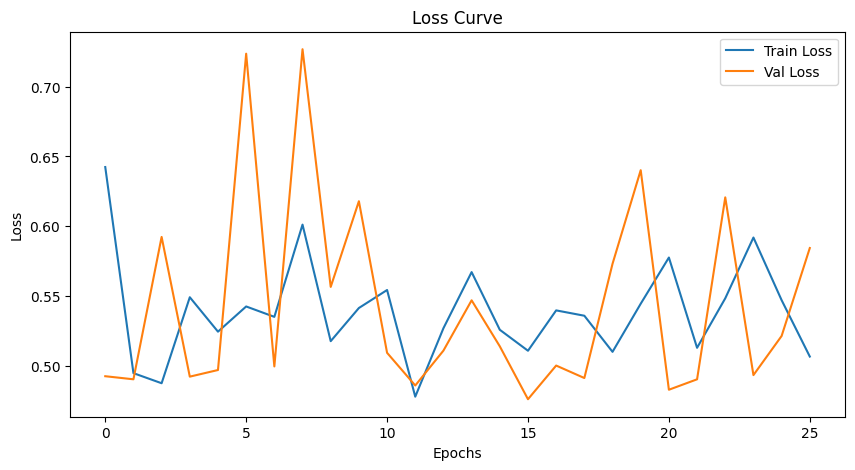

In [72]:
# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()


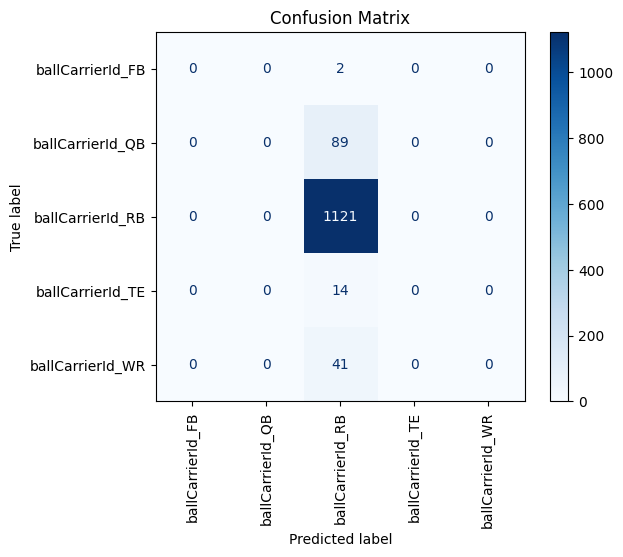

Validation Accuracy: 0.9539068666140489


In [73]:
# Evaluation
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for data in val_loader:
        out = model(data)
        pred = torch.sigmoid(out) >= 0.5  # Apply sigmoid and threshold at 0.5
        all_preds.append(pred.cpu().numpy())
        all_targets.append(data.y.view_as(pred).cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Compute confusion matrix for all classes combined
cm = confusion_matrix(all_targets.argmax(axis=1), all_preds.argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_df.columns)
cm_display.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

accuracy = np.mean(all_preds == all_targets)
print(f'Validation Accuracy: {accuracy}')